# US Airline Sentiment Analysis

## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from mlxtend.plotting import plot_confusion_matrix
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/pawan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Reading the data

In [2]:
raw_data = pd.read_csv('Tweets.csv', delimiter=',')
raw_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Shape of the dataset

In [3]:
print(raw_data.shape)

(14640, 15)


### Checking the Null fields

In [4]:
raw_data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

### To get a better idea, lets calculate the percentage of nulls or NA values in each column

In [5]:
((raw_data.isnull() | raw_data.isna()).sum() * 100 / raw_data.index.size).round(2)

tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

### tweet_coord , airline_sentiment_gold, negativereason_gold have more than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.

In [6]:
del raw_data['tweet_coord']
del raw_data['airline_sentiment_gold']
del raw_data['negativereason_gold']
raw_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


1.   Firstly lets calculate the total number of tweets for each airline
2.   This will give us a clearer idea about the airline sentiments , airlines relationship.



Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


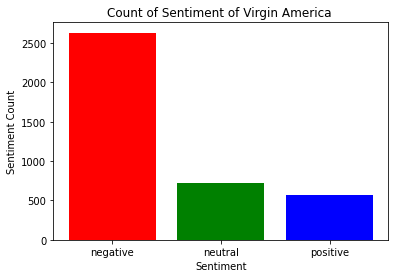

In [7]:
print("Total number of tweets for each airline \n ",raw_data.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
# plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    new_df=raw_data[raw_data['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Count of Sentiment of %s '% str(i))

*   United, US Airways, American substantially get negative reactions.
*   Tweets for Virgin America are the most balanced.

### Printing the first 5 rows for text and airline_sentiment

In [8]:
raw_data[['text', 'airline_sentiment']].head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


### Substituting the string sentiment with numerical value

In [9]:
raw_data['airline_sentiment'] = raw_data['airline_sentiment'].replace('neutral', 1)
raw_data['airline_sentiment'] = raw_data['airline_sentiment'].replace('negative', 0)
raw_data['airline_sentiment'] = raw_data['airline_sentiment'].replace('positive', 2)

### Creating new DataFrame containing only Tweets and Sentiments

In [10]:
data = raw_data[['text', 'airline_sentiment']].copy()
data.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


### Creating the Dependent and result columns

In [11]:
X = data['text']
y = data['airline_sentiment']

Declaring the method for 
* Html tag removal.
* Tokenization.
* Remove the numbers.
* Removal of Special Characters and Punctuations.
* Conversion to lowercase
* Join the words in the list to convert back to text string in the data frame.
* Lemmatization.

In [12]:
nlp = spacy.load('en_core_web_sm')

### Function for removing HTML tags

In [13]:
def html_tag_removal(raw_text):
    return BeautifulSoup(raw_text).get_text()

### Function for removing Numbers and special characters

In [14]:
def remove_numbers(raw_text):
    return re.sub("[^a-zA-Z]", " ", raw_text)

### Function for converting text to lower case and tokenization

In [15]:
def tokenize_lower_case(raw_text):
    return raw_text.lower().split()

### Function for removing the stop words

In [16]:
stops = set(stopwords.words("english"))
def remove_stop_words(raw_text):
    return [w for w in raw_text if not w in stops]

### Function for Lemmatization

In [17]:
def lemmatize_text(text):
    text = nlp(text)
    return [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text]

### Function for converting string list to clean text

In [18]:
def join_words(words):
    return " ".join(words)

In [19]:
def pre_process_text(raw_text):
  review_text = html_tag_removal(raw_text)
  letters_only = remove_numbers(review_text)
  words = tokenize_lower_case(letters_only)
  meaningful_words = remove_stop_words(words)
  lemmatize_words = lemmatize_text(" ".join(meaningful_words))
  return join_words(lemmatize_words)

### Creating the clean data

In [20]:
clean_data = []
for i in range(0, X.shape[0]):
  clean_data.append(pre_process_text(X[i]))

### Printing the first 5 tweets after pre-processing

In [21]:
for i in range(5):
    print(clean_data[i])

virginamerica dhepburn say
virginamerica plus add commercial experience tacky
virginamerica today must mean need take another trip
virginamerica really aggressive blast obnoxious entertainment guest face little recourse
virginamerica really big bad thing


### Splitting the data into training set and test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

### Creating the Count Vectorizer

In [23]:
vectorizer = CountVectorizer(analyzer = "word")
train_features= vectorizer.fit_transform(X_train)

test_features=vectorizer.transform(X_test)

### Creating Classifiers

In [24]:
Classifiers = [DecisionTreeClassifier(),RandomForestClassifier(n_estimators=200)]
Accuracy=[]
Model=[]

### Training the classifiers and testing the performance

Accuracy of DecisionTreeClassifier is 0.6837431693989071
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2847
           1       0.44      0.44      0.44       919
           2       0.53      0.60      0.57       626

    accuracy                           0.68      4392
   macro avg       0.59      0.61      0.60      4392
weighted avg       0.69      0.68      0.69      4392



<Figure size 432x288 with 0 Axes>

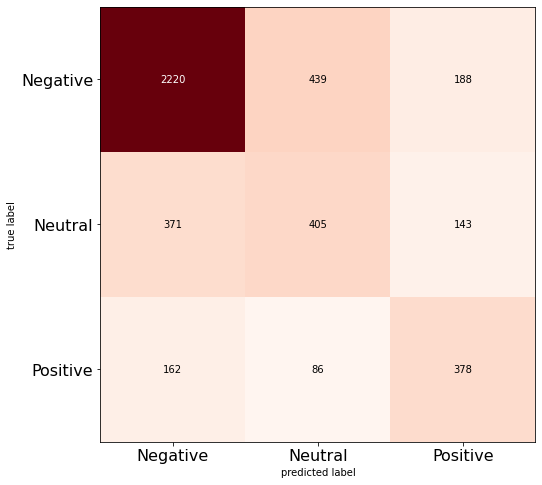

Accuracy of RandomForestClassifier is 0.7520491803278688
              precision    recall  f1-score   support

           0       0.97      0.76      0.85      3512
           1       0.36      0.67      0.47       501
           2       0.44      0.82      0.57       379

    accuracy                           0.75      4392
   macro avg       0.59      0.75      0.63      4392
weighted avg       0.85      0.75      0.78      4392



<Figure size 432x288 with 0 Axes>

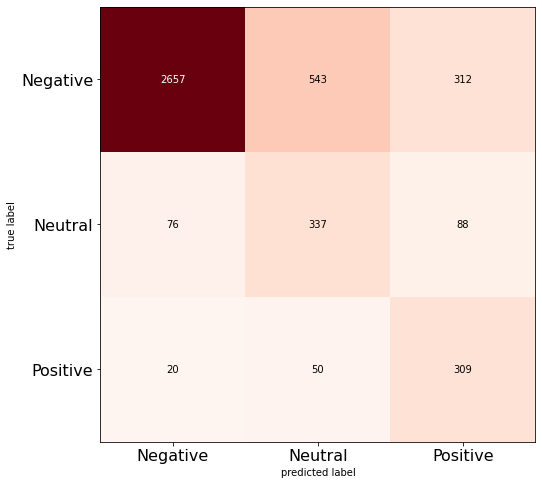

In [25]:
for classifier in Classifiers:
  fit = classifier.fit(train_features, y_train)
  pred = fit.predict(test_features)

  accuracy = accuracy_score(pred,y_test)
  Accuracy.append(accuracy)
  Model.append(classifier.__class__.__name__)

  print('Accuracy of %s is %s' % (classifier.__class__.__name__, str(accuracy)))
  print(classification_report(pred,y_test))
  cm=confusion_matrix(pred , y_test)
  plt.figure()

  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
  plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
  plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
  plt.show()

## Conclusion
### As we can see from the above stats we can conclude that, Random Forest Classifier gives us the best accuracy score, precision scores according to the classification report.

### Creating Tfidf Vectorizer

In [26]:

vectorizer = TfidfVectorizer()
train_features= vectorizer.fit_transform(X_train)

test_features=vectorizer.transform(X_test)

### Creating Classifiers

In [27]:
Classifiers = [DecisionTreeClassifier(),RandomForestClassifier(n_estimators=200)]
Accuracy=[]
Model=[]

### Training the classifiers and testing the performance

Accuracy of DecisionTreeClassifier is 0.6621129326047359
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      2747
           1       0.44      0.42      0.43       979
           2       0.51      0.54      0.52       666

    accuracy                           0.66      4392
   macro avg       0.57      0.58      0.58      4392
weighted avg       0.66      0.66      0.66      4392



<Figure size 432x288 with 0 Axes>

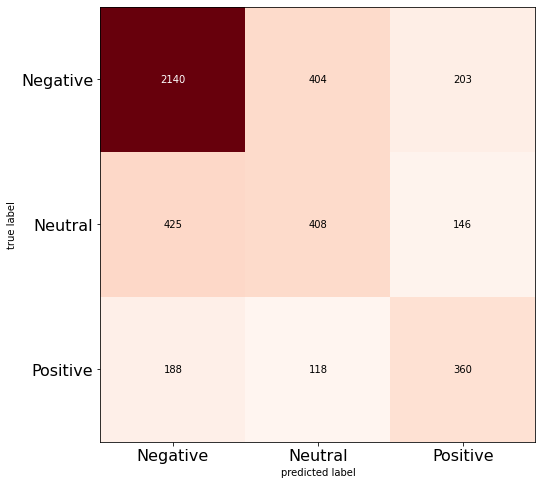

Accuracy of RandomForestClassifier is 0.7497723132969034
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3579
           1       0.35      0.70      0.47       470
           2       0.40      0.83      0.54       343

    accuracy                           0.75      4392
   macro avg       0.58      0.76      0.62      4392
weighted avg       0.86      0.75      0.78      4392



<Figure size 432x288 with 0 Axes>

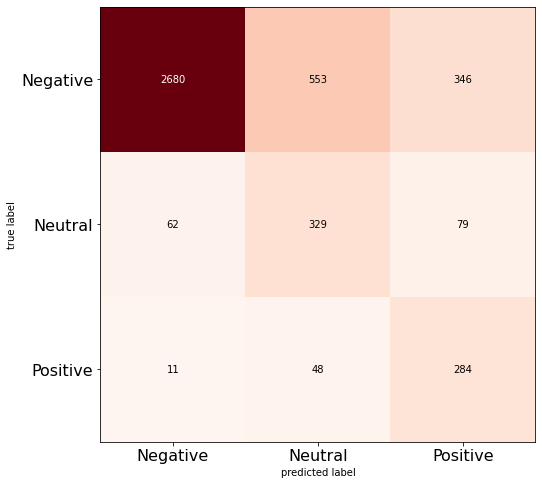

In [28]:
for classifier in Classifiers:
  fit = classifier.fit(train_features, y_train)
  pred = fit.predict(test_features)

  accuracy = accuracy_score(pred,y_test)
  Accuracy.append(accuracy)
  Model.append(classifier.__class__.__name__)

  print('Accuracy of %s is %s' % (classifier.__class__.__name__, str(accuracy)))
  print(classification_report(pred,y_test))
  cm=confusion_matrix(pred , y_test)
  plt.figure()

  plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Reds)
  plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16,color='black')
  plt.yticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=16)
  plt.show()

## Conclusion
### As we can see from the above stats we can conclude that, Random Forest Classifier gives us the best accuracy score, precision scores according to the classification report. Once again Random Forest Classifier has out performed the Decision Tree Classifier.

## Additional data insights

In [32]:
raw_data = pd.read_csv('Tweets.csv', delimiter=',')
date = raw_data.reset_index()
date.tweet_created = pd.to_datetime(date.tweet_created)
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
df = date
day_df = df.groupby(['tweet_created','airline','airline_sentiment']).size()
print(day_df)

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64


### This shows the sentiments of tweets for each date from 2015-02-16 to 2015-02-24 for every airline in our dataframe.

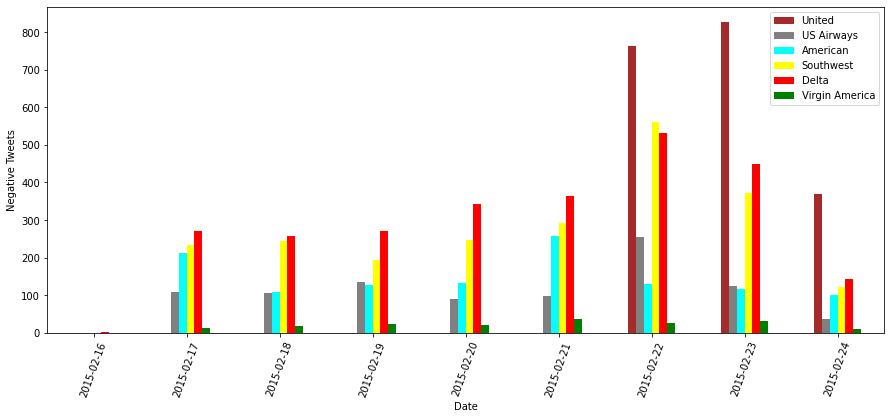

In [36]:
day_df = day_df.loc(axis=0)[:,:,'negative']
ax2 = day_df.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['brown','gray','cyan','yellow', 'red', 'green'], figsize = (15,6), rot = 70)
labels = ['United','US Airways','American','Southwest','Delta','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

* Delta has had a sudden surge of negative tweets on 22nd and 23rd, which has reduced on 24th.
* Virgin America has the least number of negative tweets for the dates for which data is available